In [1]:
# Create Date    : 2025/05/07
# Modify Date    : 2025/12/24
# Python Version : 3.12.7-amd64
# Cuda   Version : 12.4.0_551.61_windows
# Cudnn  Version : 9.1.1_windows
# CPU    Version : Intel(R) Core(TM) i7-14700F 2.10 GHz
# GPU    Version : NVIDIA GeForce RTX 4090 D
############################################################################################################################
import io
import os
from PIL import Image
import numpy as np                      # numpy: 1.26.3
import torch                            # torch: 2.6.0+cu124
from torch import nn
import matplotlib.pyplot as plt         # matplotlib: 3.9.2
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
import FSNanalysis as fsn               # custom module: FSNanalysis.py
import _pickle as pickle
# Set the image saving path
saveFile                = "./figure/"
# Path for saving the prediction results of California housing prices data
path                    = "./FSNPerformance"
target_file             = "20251218_084459"


Function Loss:  0.09532795651953108
Spectrum Loss:  0.0


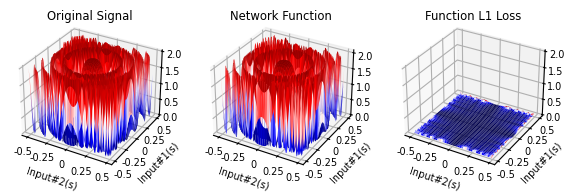

In [2]:
# Verify the reverse solution of the single-layer network
class ComplexExp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inputs):
        outputs         = (inputs * 2j * np.pi).exp()
        ctx.save_for_backward(outputs)
        return outputs
    @staticmethod
    def backward(ctx, grad_output):
        outputs,        = ctx.saved_tensors
        return grad_output * outputs
class TestModel(torch.nn.Module):
    def __init__(self, nodes):
        super().__init__()
        self.Linear_1   = nn.Linear(2, nodes, dtype = complex)
        self.Linear_2   = nn.Linear(nodes, 1, dtype = complex)
    def forward(self, inputs):
        layer_1         = self.Linear_1(inputs)
        activation      = ComplexExp.apply(layer_1)
        outputs         = self.Linear_2(activation)
        return outputs
T                       = 1
C                       = [0, 1, 0]
fs                      = [100, 100]
x                       = np.array([i / fs[0] for i in range(-int(fs[0] / 2), int(fs[0] / 2))], dtype = complex)
y                       = np.array([i / fs[1] for i in range(-int(fs[1] / 2), int(fs[1] / 2))], dtype = complex)
g                       = np.zeros((fs[0], fs[1], 1), dtype = complex)
for i, xi in enumerate(x):
    for j, yj in enumerate(y):
        g[i, j, 0]      = np.cos(20 * np.pi * (yj ** 2 + xi ** 2)) + 1
spectrum, F             = fsn.dataProcess_FFT(g, fs)
direction, amplifier, spectrum_rebuild = fsn.singleLayer(fs, T, C, spectrum[: , : , 0])
testModel               = TestModel(len(direction) - 1)
modelDict               = testModel.state_dict()
parameter               = [direction[1: , : ], np.array([0 for i in range(len(direction) - 1)], dtype = complex), amplifier.T[: , 1: ], amplifier.T[: , 0]]
for key, value in zip(modelDict, parameter):
    modelDict[key]      = torch.from_numpy(value)
testModel.load_state_dict(modelDict)
fs_test                 = [128, 128]
g_test                  = np.zeros((fs_test[0], fs_test[1], 1), dtype = complex)
xy                      = np.zeros((fs_test[0], fs_test[1], 2), dtype = complex)
x_test                  = np.array([i / fs_test[0] for i in range(-int(fs_test[0] / 2), int(fs_test[0] / 2))], dtype = complex)
y_test                  = np.array([i / fs_test[1] for i in range(-int(fs_test[1] / 2), int(fs_test[1] / 2))], dtype = complex)
for i, xi in enumerate(x_test):
    for j, yj in enumerate(y_test):
        g_test[i, j, 0] = np.cos(20 * np.pi * (yj ** 2 + xi ** 2)) + 1
for i, xx in enumerate(np.fft.fftshift(x_test)):
    for j, yy in enumerate(np.fft.fftshift(y_test)):
        xy[i, j, 0], xy[i, j, 1]        = (xx, yy)
testModel.eval()
with torch.no_grad():
    prediction          = testModel(torch.from_numpy(xy)).numpy()
spectrum                = np.abs(np.fft.fftshift(spectrum, axes = (0, 1)))
spectrum_rebuild        = np.abs(np.fft.fftshift(spectrum_rebuild, axes = (0, 1)))
g                       = np.abs(g)
g_test                  = np.abs(g_test)
prediction              = np.abs(prediction)
F                       = [np.fft.fftshift(f) for f in F]
(X, Y)                  = np.meshgrid(np.real(y), np.real(x))
(X_test, Y_test)        = np.meshgrid(np.real(y_test), np.real(x_test))
(Fx, Fy)                = np.meshgrid(F[1], F[0])
fig                     = plt.figure(figsize = (7, 2.5))
plt.rcParams['font.size']               = 7
plt.rcParams['font.family']             = 'sans-serif'
ax                      = plt.subplot(131, projection = '3d')
ax.plot_surface(X, Y, g[: , : , 0], cmap = plt.cm.seismic)
plt.title('Original Signal', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
plt.xticks([-0.5, -0.25, 0, 0.25, 0.5], ['-0.5', '-0.25', '0', '0.25', '0.5'])
plt.yticks([-0.5, -0.25, 0, 0.25, 0.5], ['-0.5', '-0.25', '0', '0.25', '0.5'])
ax.set_zticks([0, 0.5, 1, 1.5, 2], ['0.0', '0.5', '1.0', '1.5', '2.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
ax                      = plt.subplot(132, projection = '3d')
ax.plot_surface(X_test, Y_test, prediction[: , : , 0], cmap = plt.cm.seismic)
plt.title('Network Function', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
plt.xticks([-0.5, -0.25, 0, 0.25, 0.5], ['-0.5', '-0.25', '0', '0.25', '0.5'])
plt.yticks([-0.5, -0.25, 0, 0.25, 0.5], ['-0.5', '-0.25', '0', '0.25', '0.5'])
ax.set_zticks([0, 0.5, 1, 1.5, 2], ['0.0', '0.5', '1.0', '1.5', '2.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
ax                      = plt.subplot(133, projection = '3d')
ax.plot_surface(X_test, Y_test, np.abs(g_test[: , : , 0] - prediction[: , : , 0]), cmap = plt.cm.seismic)
plt.title('Function L1 Loss', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
ax.set_zlim(0, np.max(g[: , : , 0]))
plt.xticks([-0.5, -0.25, 0, 0.25, 0.5], ['-0.5', '-0.25', '0', '0.25', '0.5'])
plt.yticks([-0.5, -0.25, 0, 0.25, 0.5], ['-0.5', '-0.25', '0', '0.25', '0.5'])
ax.set_zticks([0, 0.5, 1, 1.5, 2], ['0.0', '0.5', '1.0', '1.5', '2.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
'''
ax                      = plt.subplot(234, projection = '3d')
ax.plot_surface(Fx, Fy, spectrum[: , : , 0], cmap = plt.cm.seismic)
plt.title('Original Spectrum', y = 1)
plt.xlabel('Input#2(Hz)', labelpad = -6)
plt.ylabel('Input#1(Hz)', labelpad = -6)
plt.xticks([-50, -25, 0, 25, 50], ['-50', '-25', '0', '25', '50'])
plt.yticks([-50, -25, 0, 25, 50], ['-50', '-25', '0', '25', '50'])
ax.set_zticks([0, 0.5, 1], ['0.0', '0.5', '1.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
ax                      = plt.subplot(235, projection = '3d')
ax.plot_surface(Fx, Fy, spectrum_rebuild, cmap = plt.cm.seismic)
plt.title('Network Spectrum', y = 1)
plt.xlabel('Input#2(Hz)', labelpad = -6)
plt.ylabel('Input#1(Hz)', labelpad = -6)
plt.xticks([-50, -25, 0, 25, 50], ['-50', '-25', '0', '25', '50'])
plt.yticks([-50, -25, 0, 25, 50], ['-50', '-25', '0', '25', '50'])
ax.set_zticks([0, 0.5, 1], ['0.0', '0.5', '1.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
ax                      = plt.subplot(236, projection = '3d')
ax.plot_surface(Fx, Fy, np.abs(spectrum[: , : , 0] - spectrum_rebuild), cmap = plt.cm.seismic)
plt.title('Spectrum L1 Loss', y = 1)
plt.xlabel('Input#2(Hz)', labelpad = -6)
plt.ylabel('Input#1(Hz)', labelpad = -6)
ax.set_zlim(0, np.max(spectrum[: , : , 0]))
plt.xticks([-50, -25, 0, 25, 50], ['-50', '-25', '0', '25', '50'])
plt.yticks([-50, -25, 0, 25, 50], ['-50', '-25', '0', '25', '50'])
ax.set_zticks([0, 0.5, 1], ['0.0', '0.5', '1.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
'''
png                     = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
tiff                    = Image.open(png)
tiff.save(saveFile + 'SingleLayer.tiff')
png.close()
print('Function Loss: ', np.max(np.abs(g_test[: , : , 0] - prediction[: , : , 0])))
print('Spectrum Loss: ', np.max(np.abs(spectrum[: , : , 0] - spectrum_rebuild)))


Function Loss:  2.065232382241811e-13


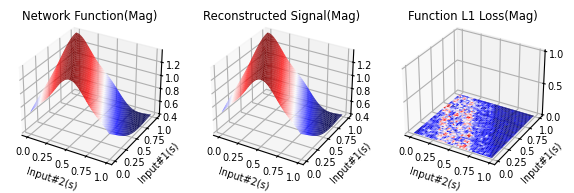

In [16]:
# Forward analysis of the spectrum of random fully connected neural networks
class ComplexExp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inputs):
        outputs         = (inputs * 2j * np.pi).exp()
        ctx.save_for_backward(outputs)
        return outputs
    @staticmethod
    def backward(ctx, grad_output):
        outputs,        = ctx.saved_tensors
        return grad_output * outputs
class x3(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inputs):
        outputs         = torch.mul(torch.mul(inputs, inputs), inputs) + inputs * 2 + 1
        ctx.save_for_backward(outputs)
        return outputs
    @staticmethod
    def backward(ctx, grad_output):
        outputs,        = ctx.saved_tensors
        return grad_output * outputs
class TestModel(torch.nn.Module):
    def __init__(self, nodes):
        super().__init__()
        self.Linear_1   = nn.Linear(2, nodes[0], dtype = complex)
        self.Linear_2   = nn.Linear(nodes[0], nodes[1], dtype = complex)
        self.Linear_3   = nn.Linear(nodes[1], nodes[2], dtype = complex)
        self.Linear_4   = nn.Linear(nodes[2], 1, dtype = complex)
    def forward(self, inputs):
        layer_1         = self.Linear_1(inputs)
        activation_1    = ComplexExp.apply(layer_1)
        layer_2         = self.Linear_2(activation_1)
        activation_2    = x3.apply(layer_2)
        layer_3         = self.Linear_3(activation_2)
        activation_3    = x3.apply(layer_3)
        layer_4         = self.Linear_4(activation_3)
        return layer_4
T                       = 1
C                       = [[0, 1, 0], [1, 2, 0, 1], [1, 2, 0, 1]]
domain                  = [[0, 1], [0, 1]]
sampleRate              = [100, 100]
testModel               = TestModel([1, 2, 1])
modelDict               = testModel.state_dict()
for i, key in enumerate(modelDict):
    modelDict[key]      = torch.from_numpy(np.real(modelDict[key].numpy()))
testModel.load_state_dict(modelDict)
spec, result_net, result_spec, loss, x  = fsn.analysis(testModel, C, T, sampleRate, domain)
(X, Y)                  = np.meshgrid(np.abs(x[1]), np.abs(x[0]))
maximum                 = np.max(np.abs(result_net[: , : , 0]))
fig                     = plt.figure(figsize = (7, 2.5))
plt.rcParams['font.size']               = 7
plt.rcParams['font.family']             = 'sans-serif'
ax                      = plt.subplot(131, projection = '3d')
ax.plot_surface(X, Y, np.abs(result_net[: , : , 0]), cmap = plt.cm.seismic)
plt.title('Network Function(Mag)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
ax.set_zlim(np.min(np.abs(result_net[: , : , 0])), np.max(np.abs(result_net[: , : , 0])))
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
ax                      = plt.subplot(132, projection = '3d')
ax.plot_surface(X, Y, np.abs(result_spec[: , : , 0]), cmap = plt.cm.seismic)
plt.title('Reconstructed Signal(Mag)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
ax.set_zlim(np.min(np.abs(result_net[: , : , 0])), np.max(np.abs(result_net[: , : , 0])))
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
ax                      = plt.subplot(133, projection = '3d')
ax.plot_surface(X, Y, np.abs(loss[: , : , 0]), cmap = plt.cm.seismic)
plt.title('Function L1 Loss(Mag)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
ax.set_zlim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
ax.set_zticks([0, 0.5, 1], ['0.0', '0.5', '1.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
'''
ax                      = plt.subplot(234, projection = '3d')
ax.plot_surface(X, Y, np.angle(result_net[: , : , 0]), cmap = plt.cm.seismic)
plt.title('Network Function(Pha)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
ax.set_zticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi], ['-π', '-π/2', '0', 'π/2', 'π'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
ax                      = plt.subplot(235, projection = '3d')
ax.plot_surface(X, Y, np.angle(result_spec[: , : , 0]), cmap = plt.cm.seismic)
plt.title('Reconstructed Signal(Pha)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
ax.set_zticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi], ['-π', '-π/2', '0', 'π/2', 'π'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
ax                      = plt.subplot(236, projection = '3d')
ax.plot_surface(X, Y, np.angle(loss[: , : , 0]), cmap = plt.cm.seismic)
plt.title('Function L1 Loss(Pha)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
ax.set_zticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi], ['-π', '-π/2', '0', 'π/2', 'π'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
'''
png                     = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
tiff                    = Image.open(png)
tiff.save(saveFile + 'MultiLayer.tiff')
png.close()
print('Function Loss: ', np.max(np.abs(loss[: , : , 0])))


Function Loss:  9.985192631036767e-13


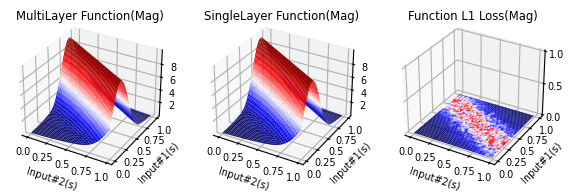

In [19]:
# Generate equivalent single-layer networks from multi-layer fully connected neural networks
class ComplexExp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inputs):
        outputs         = (inputs * 2j * np.pi).exp()
        ctx.save_for_backward(outputs)
        return outputs
    @staticmethod
    def backward(ctx, grad_output):
        outputs,        = ctx.saved_tensors
        return grad_output * outputs
class x3(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inputs):
        outputs         = torch.mul(torch.mul(inputs, inputs), inputs) + torch.mul(inputs, inputs) + inputs + 1
        ctx.save_for_backward(outputs)
        return outputs
    @staticmethod
    def backward(ctx, grad_output):
        outputs,        = ctx.saved_tensors
        return grad_output * outputs
class TestModel(torch.nn.Module):
    def __init__(self, nodes):
        super().__init__()
        self.Linear_1   = nn.Linear(2, nodes[0], dtype = complex)
        self.Linear_2   = nn.Linear(nodes[0], nodes[1], dtype = complex)
        self.Linear_3   = nn.Linear(nodes[1], nodes[2], dtype = complex)
        self.Linear_4   = nn.Linear(nodes[2], 1, dtype = complex)
    def forward(self, inputs):
        layer_1         = self.Linear_1(inputs)
        activation_1    = ComplexExp.apply(layer_1)
        layer_2         = self.Linear_2(activation_1)
        activation_2    = x3.apply(layer_2)
        layer_3         = self.Linear_3(activation_2)
        activation_3    = x3.apply(layer_3)
        layer_4         = self.Linear_4(activation_3)
        return layer_4
class TestModel_single(torch.nn.Module):
    def __init__(self, nodes):
        super().__init__()
        self.Linear_1   = nn.Linear(2, nodes, dtype = complex)
        self.Linear_2   = nn.Linear(nodes, 1, dtype = complex)
    def forward(self, inputs):
        layer_1         = self.Linear_1(inputs)
        activation      = ComplexExp.apply(layer_1)
        outputs         = self.Linear_2(activation)
        return outputs
T                       = 1
C                       = [[0, 1, 0], [1, 1, 1, 1], [1, 1, 1, 1]]
fs                      = [100, 100]
domain                  = [[0, 1], [0, 1]]
f_border                = [0, 0]
testModel               = TestModel([1, 2, 1])
modelDict               = testModel.state_dict()
for i, key in enumerate(modelDict):
    modelDict[key]      = torch.from_numpy(np.real(modelDict[key].numpy()))
testModel.load_state_dict(modelDict)
dir, amp, bias          = fsn.multi_to_single(testModel, C, T, f_border)
nodes                   = len(amp)
singleModel             = TestModel_single(nodes)
modelDict               = singleModel.state_dict()
parameter               = [dir, np.array([0 for i in range(nodes)], dtype = complex), amp.T, bias]
for key, value in zip(modelDict, parameter):
    modelDict[key]      = torch.from_numpy(value)
singleModel.load_state_dict(modelDict)
x                       = np.array([i / fs[0] for i in range(fs[0])], dtype = complex)
y                       = np.array([i / fs[1] for i in range(fs[1])], dtype = complex)
xy                      = np.zeros((fs[0], fs[1], 2), dtype = complex)
for i, xx in enumerate(x):
    for j, yy in enumerate(y):
        xy[i, j, 0], xy[i, j, 1]        = (xx, yy)
testModel.eval()
with torch.no_grad():
    prediction_1        = testModel(torch.from_numpy(xy)).numpy()
    prediction_2        = singleModel(torch.from_numpy(xy)).numpy()
loss                    = prediction_1[: , : , 0] - prediction_2[: , : , 0]
(X, Y)                  = np.meshgrid(np.abs(y), np.abs(x))
fig                     = plt.figure(figsize = (7, 2.5))
plt.rcParams['font.size']               = 7
plt.rcParams['font.family']             = 'sans-serif'
ax                      = plt.subplot(131, projection = '3d')
ax.plot_surface(X, Y, np.abs(prediction_1[: , : , 0]), cmap = plt.cm.seismic)
plt.title('MultiLayer Function(Mag)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
ax.set_zlim(np.min(np.abs(prediction_1[: , : , 0])), np.max(np.abs(prediction_1[: , : , 0])))
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
ax                      = plt.subplot(132, projection = '3d')
ax.plot_surface(X, Y, np.abs(prediction_2[: , : , 0]), cmap = plt.cm.seismic)
plt.title('SingleLayer Function(Mag)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
ax.set_zlim(np.min(np.abs(prediction_1[: , : , 0])), np.max(np.abs(prediction_1[: , : , 0])))
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
ax                      = plt.subplot(133, projection = '3d')
ax.plot_surface(X, Y, np.abs(loss), cmap = plt.cm.seismic)
plt.title('Function L1 Loss(Mag)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
ax.set_zlim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
ax.set_zticks([0, 0.5, 1], ['0.0', '0.5', '1.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
'''
ax                      = plt.subplot(234, projection = '3d')
ax.plot_surface(X, Y, np.angle(prediction_1[: , : , 0]), cmap = plt.cm.seismic)
plt.title('MultiLayer Function(Pha)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
ax.set_zticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi], ['-π', '-π/2', '0', 'π/2', 'π'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
ax                      = plt.subplot(235, projection = '3d')
ax.plot_surface(X, Y, np.angle(prediction_2[: , : , 0]), cmap = plt.cm.seismic)
plt.title('SingleLayer Function(Pha)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
ax.set_zticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi], ['-π', '-π/2', '0', 'π/2', 'π'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
ax                      = plt.subplot(236, projection = '3d')
ax.plot_surface(X, Y, np.angle(loss), cmap = plt.cm.seismic)
plt.title('Function L1 Loss(Pha)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
ax.set_zticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi], ['-π', '-π/2', '0', 'π/2', 'π'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
'''
png                     = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
tiff                    = Image.open(png)
tiff.save(saveFile + 'MultyToSingle.tiff')
png.close()
print('Function Loss: ', np.max(np.abs(loss)))


Function#1 Loss:  0.39909995
Function#2 Loss:  3.9339066e-06


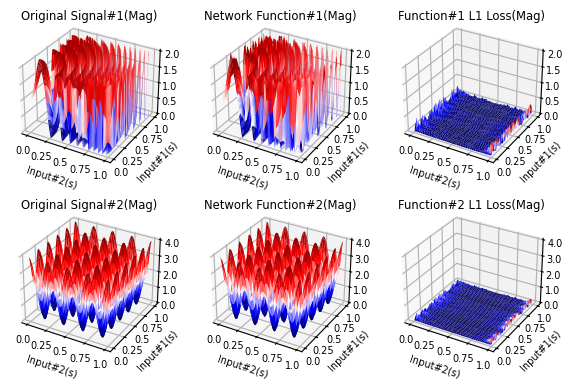

In [3]:
# Generate the FSN network from the spectrum
fs                      = [400, 400]
x                       = np.array([i / fs[0] for i in range(fs[0])], dtype = np.float32)
y                       = np.array([i / fs[1] for i in range(fs[1])], dtype = np.float32)
g                       = np.zeros((fs[0], fs[1], 2), dtype = np.float32)
for i, xi in enumerate(x):
    for j, yj in enumerate(y):
        g[i, j, 0]      = np.sin(10 * np.pi * (xi ** 2 + 2 * yj ** 2)) + 1
        g[i, j, 1]      = np.cos(10 * np.pi * xi) + np.cos(8 * np.pi * yj) + 2
fs_test                 = [128, 128]
x_test                  = np.array([i / fs_test[0] for i in range(fs_test[0])], dtype = np.float32)
y_test                  = np.array([i / fs_test[1] for i in range(fs_test[1])], dtype = np.float32)
g_test                  = np.zeros((fs_test[0], fs_test[1], 2), dtype = np.float32)
for i, xi in enumerate(x_test):
    for j, yj in enumerate(y_test):
        g_test[i, j, 0] = np.sin(10 * np.pi * (xi ** 2 + 2 * yj ** 2)) + 1
        g_test[i, j, 1] = np.cos(10 * np.pi * xi) + np.cos(8 * np.pi * yj) + 2
spectrum, F             = fsn.dataProcess_FFT(g, fs)
model                   = fsn.FSN(spectrum, [[3, 3], [3, 3]], fs, complexEnable = False)
xy                      = np.zeros((fs_test[0], fs_test[1], 2), dtype = np.float32)
for i, xx in enumerate(x_test):
    for j, yy in enumerate(y_test):
        xy[i, j, 0], xy[i, j, 1]        = (xx, yy)
model.eval()
with torch.no_grad():
    prediction          = model(torch.from_numpy(xy)).numpy()
maximum                 = [np.max(np.abs(g[: , : , 0])), np.max(np.abs(g[: , : , 1]))]
(X, Y)                  = np.meshgrid(np.abs(y), np.abs(x))
(X_test, Y_test)        = np.meshgrid(np.abs(y_test), np.abs(x_test))
loss                    = g_test - prediction
fig                     = plt.figure(figsize = (7, 4.5))
plt.rcParams['font.size']               = 7
plt.rcParams['font.family']             = 'sans-serif'
ax                      = plt.subplot(231, projection = '3d')
ax.plot_surface(X, Y, np.abs(g[: , : , 0]), cmap = plt.cm.seismic)
plt.title('Original Signal#1(Mag)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
ax.set_zlim(0, maximum[0])
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
ax.set_zticks([0, 0.5, 1, 1.5, 2], ['0.0', '0.5', '1.0', '1.5', '2.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
ax                      = plt.subplot(232, projection = '3d')
ax.plot_surface(X_test, Y_test, np.abs(prediction[: , : , 0]), cmap = plt.cm.seismic)
plt.title('Network Function#1(Mag)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
ax.set_zlim(0, maximum[0])
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
ax.set_zticks([0, 0.5, 1, 1.5, 2], ['0.0', '0.5', '1.0', '1.5', '2.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
ax                      = plt.subplot(233, projection = '3d')
ax.plot_surface(X_test, Y_test, np.abs(loss[: , : , 0]), cmap = plt.cm.seismic)
plt.title('Function#1 L1 Loss(Mag)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
ax.set_zlim(0, maximum[0])
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
ax.set_zticks([0, 0.5, 1, 1.5, 2], ['0.0', '0.5', '1.0', '1.5', '2.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
ax                      = plt.subplot(234, projection = '3d')
ax.plot_surface(X, Y, np.abs(g[: , : , 1]), cmap = plt.cm.seismic)
plt.title('Original Signal#2(Mag)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
ax.set_zlim(0, maximum[1])
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
ax.set_zticks([0, 1, 2, 3, 4], ['0.0', '1.0', '2.0', '3.0', '4.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
ax                      = plt.subplot(235, projection = '3d')
ax.plot_surface(X_test, Y_test, np.abs(prediction[: , : , 1]), cmap = plt.cm.seismic)
plt.title('Network Function#2(Mag)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
ax.set_zlim(0, maximum[1])
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
ax.set_zticks([0, 1, 2, 3, 4], ['0.0', '1.0', '2.0', '3.0', '4.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
ax                      = plt.subplot(236, projection = '3d')
ax.plot_surface(X_test, Y_test, np.abs(loss[: , : , 0]), cmap = plt.cm.seismic)
plt.title('Function#2 L1 Loss(Mag)', y = 1)
plt.xlabel('Input#2(s)', labelpad = -6)
plt.ylabel('Input#1(s)', labelpad = -6)
ax.set_zlim(0, maximum[1])
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0.0', '0.25', '0.5', '0.75', '1.0'])
ax.set_zticks([0, 1, 2, 3, 4], ['0.0', '1.0', '2.0', '3.0', '4.0'])
plt.tick_params(axis = 'x', pad = -3)
plt.tick_params(axis = 'y', pad = -3)
plt.tick_params(axis = 'z', pad = -3)
png                     = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
tiff                    = Image.open(png)
tiff.save(saveFile + 'FSNtest.tiff')
png.close()
print('Function#1 Loss: ', np.max(np.abs(loss[: , : , 0])))
print('Function#2 Loss: ', np.max(np.abs(loss[: , : , 1])))


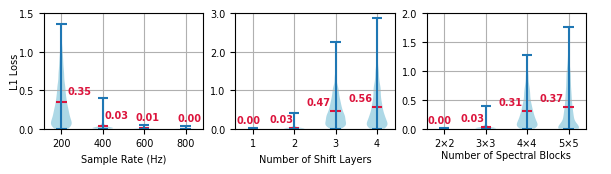

In [4]:
# Loss analysis of the FSN network
fs                      = [64, 64]
x                       = np.array([i / fs[0] for i in range(fs[0])], dtype = np.float32)
y                       = np.array([i / fs[1] for i in range(fs[1])], dtype = np.float32)
g_test                  = np.zeros((fs[0], fs[1], 1), dtype = np.float32)
xy                      = np.zeros((fs[0], fs[1], 2), dtype = np.float32)
for i, xi in enumerate(x):
    for j, yj in enumerate(y):
        g_test[i, j, 0] = np.sin(10 * np.pi * (xi ** 2 + 2 * yj ** 2)) + 1
        xy[i, j, 0], xy[i, j, 1]        = (xi, yj)
loss1                   = []
fs_candidate            = [200 * i for i in range(1, 5)]
for f in fs_candidate:
    fs                  = [f, f]
    blocks              = [[3, 3], [3, 3]]
    x                   = np.array([i / fs[0] for i in range(fs[0])], dtype = np.float32)
    y                   = np.array([i / fs[1] for i in range(fs[1])], dtype = np.float32)
    g                   = np.zeros((fs[0], fs[1], 1), dtype = np.float32)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            g[i, j, 0]  = np.sin(10 * np.pi * (xi ** 2 + 2 * yj ** 2)) + 1
    spectrum, F         = fsn.dataProcess_FFT(g, fs)
    model               = fsn.FSN(spectrum, blocks, fs, complexEnable = False)
    model.eval()
    with torch.no_grad():
        prediction      = model(torch.from_numpy(xy)).numpy()
    loss1.append(np.abs(g_test - prediction).flatten())
loss2                   = []
blocks_candidate        = [1, 2, 3, 4]
for block in blocks_candidate:
    fs                  = [400, 400]
    blocks              = [[3, 3] for i in range(block)]
    x                   = np.array([i / fs[0] for i in range(fs[0])], dtype = np.float32)
    y                   = np.array([i / fs[1] for i in range(fs[1])], dtype = np.float32)
    g                   = np.zeros((fs[0], fs[1], 1), dtype = np.float32)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            g[i, j, 0]  = np.sin(10 * np.pi * (xi ** 2 + 2 * yj ** 2)) + 1
    spectrum, F         = fsn.dataProcess_FFT(g, fs)
    model               = fsn.FSN(spectrum, blocks, fs, complexEnable = False)
    model.eval()
    with torch.no_grad():
        prediction      = model(torch.from_numpy(xy)).numpy()
    loss2.append(np.abs(g_test - prediction).flatten())
loss3                   = []
size_candidate          = [2, 3, 4, 5]
for size in size_candidate:
    fs                  = [400, 400]
    blocks              = [[size, size], [size, size]]
    x                   = np.array([i / fs[0] for i in range(fs[0])], dtype = np.float32)
    y                   = np.array([i / fs[1] for i in range(fs[1])], dtype = np.float32)
    g                   = np.zeros((fs[0], fs[1], 1), dtype = np.float32)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            g[i, j, 0]  = np.sin(10 * np.pi * (xi ** 2 + 2 * yj ** 2)) + 1
    spectrum, F         = fsn.dataProcess_FFT(g, fs)
    model               = fsn.FSN(spectrum, blocks, fs, complexEnable = False)
    model.eval()
    with torch.no_grad():
        prediction      = model(torch.from_numpy(xy)).numpy()
    loss3.append(np.abs(g_test - prediction).flatten())
'''
fig                     = plt.figure(figsize = (7, 1.5))
plt.rcParams['font.size']               = 7
plt.rcParams['font.family']             = 'sans-serif'
ax                      = plt.subplot(131)
plt.boxplot(loss1, patch_artist = True, showmeans = True,
            boxprops = dict(color = 'k', facecolor = 'lightblue'),
            medianprops = dict(color = 'crimson', linewidth = 2),
            meanprops= dict(color = 'royalblue'),
            whiskerprops = dict(color = 'k', linewidth = 1), 
            flierprops = dict(marker ='.', markersize = 3))
plt.xlabel('Sample Rate (Hz)')
plt.ylabel('L1 Loss', labelpad = -1)
plt.ylim(0, 1.5)
plt.xticks([1, 2, 3, 4], ['%d'%fs for fs in fs_candidate])
plt.yticks([0, 0.5, 1, 1.5], ['0.0', '0.5', '1.0', '1.5'])
plt.grid('on')
plt.text(1.25, np.median(loss1[0]) + 0.1, '%.2f'%np.median(loss1[0]), color = 'red')
plt.text(2.1, np.median(loss1[1]) + 0.1, '%.2f'%np.median(loss1[1]), color = 'red')
plt.text(3, np.median(loss1[2]) + 0.1, '%.2f'%np.median(loss1[2]), color = 'red')
plt.text(4, np.median(loss1[3]) + 0.1, '%.2f'%np.median(loss1[3]), color = 'red')
ax                      = plt.subplot(132)
plt.boxplot(loss2, patch_artist = True,
            boxprops = dict(color = 'k', facecolor = 'lightblue'),
            medianprops = dict(color = 'crimson', linewidth = 2),
            whiskerprops = dict(color = 'k', linewidth = 1), 
            flierprops = dict(marker ='.', markersize = 3))
plt.xlabel('Number of Shift Layers')
plt.ylim(0, 3)
plt.xticks([1, 2, 3, 4], ['%d'%blocks for blocks in blocks_candidate])
plt.yticks([0, 1, 2, 3], ['0.0', '1.0', '2.0', '3.0'])
plt.grid('on')
plt.text(0.5, np.median(loss2[0]) + 0.1, '%.2f'%np.median(loss2[0]), color = 'red')
plt.text(1.4, np.median(loss2[1]) + 0.1, '%.2f'%np.median(loss2[1]), color = 'red')
plt.text(2.25, np.median(loss2[2]) + 0.1, '%.2f'%np.median(loss2[2]), color = 'red')
plt.text(3.25, np.median(loss2[3]) + 0.1, '%.2f'%np.median(loss2[3]), color = 'red')
ax                      = plt.subplot(133)
plt.boxplot(loss3, patch_artist = True,
            boxprops = dict(color = 'k', facecolor = 'lightblue'),
            medianprops = dict(color = 'crimson', linewidth = 2),
            whiskerprops = dict(color = 'k', linewidth = 1), 
            flierprops = dict(marker ='.', markersize = 3))
plt.xlabel('Number of Spectral Blocks', labelpad = 1)
plt.ylabel('blank', color = 'white')
ax.yaxis.set_label_position('right')
plt.ylim(0, 2)
plt.xticks([1, 2, 3, 4], ['%d×%d'%(size, size) for size in size_candidate])
plt.yticks([0, 0.5, 1, 1.5, 2], ['0.0', '0.5', '1.0', '1.5', '2.0'])
plt.grid('on')
plt.text(0.5, np.median(loss3[0]) + 0.1, '%.2f'%np.median(loss3[0]), color = 'red')
plt.text(1.4, np.median(loss3[1]) + 0.1, '%.2f'%np.median(loss3[1]), color = 'red')
plt.text(2.25, np.median(loss3[2]) + 0.1, '%.2f'%np.median(loss3[2]), color = 'red')
plt.text(3.25, np.median(loss3[3]) + 0.1, '%.2f'%np.median(loss3[3]), color = 'red')
png                     = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
tiff                    = Image.open(png)
tiff.save(saveFile + 'FSN_LossAnalysis.tiff')
png.close()
'''
fig                     = plt.figure(figsize = (7, 1.5))
plt.rcParams['font.size']               = 7
plt.rcParams['font.family']             = 'sans-serif'
ax                      = plt.subplot(131)
parts                   = plt.violinplot(loss1, showmeans = True)
for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(1)
parts['cmeans'].set_edgecolor('crimson')
plt.xlabel('Sample Rate (Hz)')
plt.ylabel('L1 Loss', labelpad = -1)
plt.ylim(0, 1.5)
plt.xticks([1, 2, 3, 4], ['%d'%fs for fs in fs_candidate])
plt.yticks([0, 0.5, 1, 1.5], ['0.0', '0.5', '1.0', '1.5'])
plt.grid('on')
plt.text(1.15, np.mean(loss1[0]) + 0.1, '%.2f'%np.mean(loss1[0]), color = 'crimson', fontweight = 'bold')
plt.text(2.05, np.mean(loss1[1]) + 0.1, '%.2f'%np.mean(loss1[1]), color = 'crimson', fontweight = 'bold')
plt.text(2.8, np.mean(loss1[2]) + 0.1, '%.2f'%np.mean(loss1[2]), color = 'crimson', fontweight = 'bold')
plt.text(3.8, np.mean(loss1[3]) + 0.1, '%.2f'%np.mean(loss1[3]), color = 'crimson', fontweight = 'bold')
ax                      = plt.subplot(132)
parts                   = plt.violinplot(loss2, showmeans = True)
for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(1)
parts['cmeans'].set_edgecolor('crimson')
plt.xlabel('Number of Shift Layers')
plt.ylim(0, 3)
plt.xticks([1, 2, 3, 4], ['%d'%blocks for blocks in blocks_candidate])
plt.yticks([0, 1, 2, 3], ['0.0', '1.0', '2.0', '3.0'])
plt.grid('on')
plt.text(0.6, np.mean(loss2[0]) + 0.15, '%.2f'%np.mean(loss2[0]), color = 'crimson', fontweight = 'bold')
plt.text(1.4, np.mean(loss2[1]) + 0.15, '%.2f'%np.mean(loss2[1]), color = 'crimson', fontweight = 'bold')
plt.text(2.3, np.mean(loss2[2]) + 0.15, '%.2f'%np.mean(loss2[2]), color = 'crimson', fontweight = 'bold')
plt.text(3.3, np.mean(loss2[3]) + 0.15, '%.2f'%np.mean(loss2[3]), color = 'crimson', fontweight = 'bold')
ax                      = plt.subplot(133)
parts                   = plt.violinplot(loss3, showmeans = True)
for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(1)
parts['cmeans'].set_edgecolor('crimson')
plt.xlabel('Number of Spectral Blocks', labelpad = 1)
plt.ylabel('blank', color = 'white')
ax.yaxis.set_label_position('right')
plt.ylim(0, 2)
plt.xticks([1, 2, 3, 4], ['%d×%d'%(size, size) for size in size_candidate])
plt.yticks([0, 0.5, 1, 1.5, 2], ['0.0', '0.5', '1.0', '1.5', '2.0'])
plt.grid('on')
plt.text(0.6, np.mean(loss3[0]) + 0.1, '%.2f'%np.mean(loss3[0]), color = 'crimson', fontweight = 'bold')
plt.text(1.4, np.mean(loss3[1]) + 0.1, '%.2f'%np.mean(loss3[1]), color = 'crimson', fontweight = 'bold')
plt.text(2.3, np.mean(loss3[2]) + 0.1, '%.2f'%np.mean(loss3[2]), color = 'crimson', fontweight = 'bold')
plt.text(3.3, np.mean(loss3[3]) + 0.1, '%.2f'%np.mean(loss3[3]), color = 'crimson', fontweight = 'bold')
png                     = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
tiff                    = Image.open(png)
tiff.save(saveFile + 'FSN_LossAnalysis.tiff')
png.close()


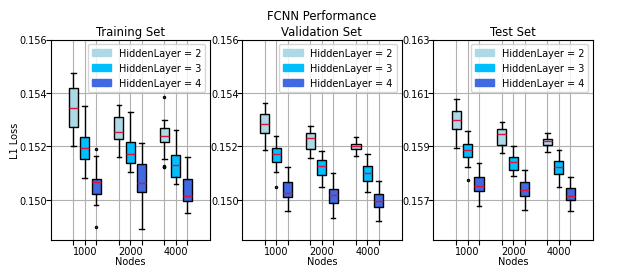

In [5]:
# California housing price data prediction results - DNN
target_path             = path + '/' + target_file + '/'
with open(target_path + 'fc2_train.pkl', 'rb') as file:
    fc2_train           = pickle.load(file)
with open(target_path + 'fc2_valid.pkl', 'rb') as file:
    fc2_valid           = pickle.load(file)
with open(target_path + 'fc2_test.pkl' , 'rb') as file:
    fc2_test            = pickle.load(file)
with open(target_path + 'fc3_train.pkl', 'rb') as file:
    fc3_train           = pickle.load(file)
with open(target_path + 'fc3_valid.pkl', 'rb') as file:
    fc3_valid           = pickle.load(file)
with open(target_path + 'fc3_test.pkl' , 'rb') as file:
    fc3_test            = pickle.load(file)
with open(target_path + 'fc4_train.pkl', 'rb') as file:
    fc4_train           = pickle.load(file)
with open(target_path + 'fc4_valid.pkl', 'rb') as file:
    fc4_valid           = pickle.load(file)
with open(target_path + 'fc4_test.pkl' , 'rb') as file:
    fc4_test            = pickle.load(file)
keys                    = list(fc2_train.keys())
fc_train                = {}
fc_valid                = {}
fc_test                 = {}
for key in keys:
    fc_train[key]       = [fc2_train[key], fc3_train[key], fc4_train[key]]
    fc_valid[key]       = [fc2_valid[key], fc3_valid[key], fc4_valid[key]]
    fc_test[key]        = [fc2_test[key], fc3_test[key], fc4_test[key]]
legend_elements         = [Patch(facecolor = 'lightblue', edgecolor = 'lightblue', label = 'HiddenLayer = 2'),
                           Patch(facecolor = 'deepskyblue', edgecolor = 'deepskyblue', label = 'HiddenLayer = 3'),
                           Patch(facecolor = 'royalblue', edgecolor = 'royalblue', label = 'HiddenLayer = 4')]
fig                     = plt.figure(figsize = (7, 2.6))
plt.rcParams['font.size']               = 7
plt.rcParams['font.family']             = 'sans-serif'
ax                      = plt.subplot(111)
plt.title('FCNN Performance', y = 1.06)
plt.axis('off')
ax                      = plt.subplot(131)
plt.boxplot(fc_train[keys[0]], patch_artist = True, positions = [0.75, 1.75, 2.75], widths = 0.2,
            boxprops = dict(color = 'k', facecolor = 'lightblue'),
            medianprops = dict(color = 'crimson', linewidth = 1),
            capprops = dict(color = 'k', linewidth = 1),
            whiskerprops = dict(color = 'k', linewidth = 1), 
            flierprops = dict(marker ='.', markersize = 3))
plt.boxplot(fc_train[keys[1]], patch_artist = True, positions = [1, 2, 3], widths = 0.2,
            boxprops = dict(color = 'k', facecolor = 'deepskyblue'),
            medianprops = dict(color = 'crimson', linewidth = 1),
            capprops = dict(color = 'k', linewidth = 1),
            whiskerprops = dict(color = 'k', linewidth = 1), 
            flierprops = dict(marker ='.', markersize = 3))
plt.boxplot(fc_train[keys[2]], patch_artist = True, positions = [1.25, 2.25, 3.25], widths = 0.2,
            boxprops = dict(color = 'k', facecolor = 'royalblue'),
            medianprops = dict(color = 'crimson', linewidth = 1),
            capprops = dict(color = 'k', linewidth = 1),
            whiskerprops = dict(color = 'k', linewidth = 1), 
            flierprops = dict(marker ='.', markersize = 3))
ax.legend(handles = legend_elements, loc = 'upper right')
plt.xticks([0.75, 1, 1.25, 1.75, 2, 2.25, 2.75, 3, 3.25],
           ['', '1000', '', '', '2000','', '', '4000', ''])
plt.yticks([0.148, 0.150, 0.152, 0.154, 0.156], ['0.148', '0.150', '0.152', '0.154', '0.156'])
plt.gca().tick_params(axis = 'x', pad = 1)
plt.gca().tick_params(axis = 'y', pad = -1)
plt.xlabel('Nodes', labelpad = 0)
plt.ylabel('L1 Loss', labelpad = -0.5)
plt.title('Training Set', y = 0.98)
plt.ylim(0.1485, 0.156)
plt.grid('on')
ax                      = plt.subplot(132)
plt.boxplot(fc_valid[keys[0]], patch_artist = True, positions = [0.75, 1.75, 2.75], widths = 0.2,
            boxprops = dict(color = 'k', facecolor = 'lightblue'),
            medianprops = dict(color = 'crimson', linewidth = 1),
            capprops = dict(color = 'k', linewidth = 1),
            whiskerprops = dict(color = 'k', linewidth = 1), 
            flierprops = dict(marker ='.', markersize = 3))
plt.boxplot(fc_valid[keys[1]], patch_artist = True, positions = [1, 2, 3], widths = 0.2,
            boxprops = dict(color = 'k', facecolor = 'deepskyblue'),
            medianprops = dict(color = 'crimson', linewidth = 1),
            capprops = dict(color = 'k', linewidth = 1),
            whiskerprops = dict(color = 'k', linewidth = 1), 
            flierprops = dict(marker ='.', markersize = 3))
plt.boxplot(fc_valid[keys[2]], patch_artist = True, positions = [1.25, 2.25, 3.25], widths = 0.2,
            boxprops = dict(color = 'k', facecolor = 'royalblue'),
            medianprops = dict(color = 'crimson', linewidth = 1),
            capprops = dict(color = 'k', linewidth = 1),
            whiskerprops = dict(color = 'k', linewidth = 1), 
            flierprops = dict(marker ='.', markersize = 3))
ax.legend(handles = legend_elements, loc = 'upper right')
plt.xticks([0.75, 1, 1.25, 1.75, 2, 2.25, 2.75, 3, 3.25],
           ['', '1000', '', '', '2000','', '', '4000', ''])
plt.yticks([0.148, 0.150, 0.152, 0.154, 0.156], ['0.148', '0.150', '0.152', '0.154', '0.156'])
plt.gca().tick_params(axis = 'x', pad = 1)
plt.gca().tick_params(axis = 'y', pad = -1)
plt.xlabel('Nodes', labelpad = 0)
plt.title('Validation Set', y = 0.98)
plt.ylim(0.1485, 0.156)
plt.grid('on')
ax                      = plt.subplot(133)
plt.boxplot(fc_test[keys[0]], patch_artist = True, positions = [0.75, 1.75, 2.75], widths = 0.2,
            boxprops = dict(color = 'k', facecolor = 'lightblue'),
            medianprops = dict(color = 'crimson', linewidth = 1),
            capprops = dict(color = 'k', linewidth = 1),
            whiskerprops = dict(color = 'k', linewidth = 1), 
            flierprops = dict(marker ='.', markersize = 3))
plt.boxplot(fc_test[keys[1]], patch_artist = True, positions = [1, 2, 3], widths = 0.2,
            boxprops = dict(color = 'k', facecolor = 'deepskyblue'),
            medianprops = dict(color = 'crimson', linewidth = 1),
            capprops = dict(color = 'k', linewidth = 1),
            whiskerprops = dict(color = 'k', linewidth = 1), 
            flierprops = dict(marker ='.', markersize = 3))
plt.boxplot(fc_test[keys[2]], patch_artist = True, positions = [1.25, 2.25, 3.25], widths = 0.2,
            boxprops = dict(color = 'k', facecolor = 'royalblue'),
            medianprops = dict(color = 'crimson', linewidth = 1),
            capprops = dict(color = 'k', linewidth = 1),
            whiskerprops = dict(color = 'k', linewidth = 1), 
            flierprops = dict(marker ='.', markersize = 3))
ax.legend(handles = legend_elements, loc = 'upper right')
plt.xticks([0.75, 1, 1.25, 1.75, 2, 2.25, 2.75, 3, 3.25],
           ['', '1000', '', '', '2000','', '', '4000', ''])
plt.yticks([0.157, 0.159, 0.161, 0.163], ['0.157', '0.159', '0.161', '0.163'])
plt.gca().tick_params(axis = 'x', pad = 1)
plt.gca().tick_params(axis = 'y', pad = -1)
ax.yaxis.set_label_position('right')
plt.title('Test Set', y = 0.98)
plt.xlabel('Nodes', labelpad = 0)
plt.ylabel('blank', color = 'white')
ax.yaxis.set_label_position('right')
plt.ylim(0.1555, 0.163)
plt.grid('on')
png                     = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
tiff                    = Image.open(png)
tiff.save(saveFile + 'DNN_performance.tiff')
png.close()


After  training:
Minimum Loss (Train): 0.03127029313304538
Minimum Loss (Valid): 0.07963536630020036
Minimum Loss (Test ): 0.07841456805485798
before training:
Maximum Loss (Train): 0.12396953604302394
Maximum Loss (Valid): 0.1334751451202098
Maximum Loss (Test ): 0.13096165865508103


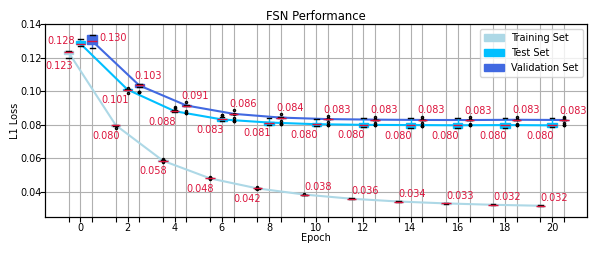

In [6]:
# California housing price data prediction results - FSN
num                     = 20
file_list               = os.listdir(path)
if len(file_list) > num - 1:
    file_list           = file_list[-num: ]
    fsn_test            = [[] for i in range(11)]
    fsn_train           = [[] for i in range(11)]
    fsn_valid           = [[] for i in range(11)]
    for i in range(num):
        target_path     = path + '/' + file_list[i] + '/'
        with open(target_path + 'fsn_test.pkl', 'rb') as file:
            target      = pickle.load(file)
            for j in range(11):
                fsn_test[j].append(target[j * 2])
        with open(target_path + 'fsn_train.pkl', 'rb') as file:
            target      = pickle.load(file)
            for j in range(11):
                fsn_train[j].append(target[j * 2])
        with open(target_path + 'fsn_valid.pkl' , 'rb') as file:
            target      = pickle.load(file)
            for j in range(11):
                fsn_valid[j].append(target[j * 2])
    x                   = [ 0.75,  1,  1.25,
                            1.75,  2,  2.25,
                            2.75,  3,  3.25,
                            3.75,  4,  4.25,
                            4.75,  5,  5.25,
                            5.75,  6,  6.25,
                            6.75,  7,  7.25,
                            7.75,  8,  8.25,
                            8.75,  9,  9.25,
                            9.75, 10, 10.25,
                           10.75, 11, 11.25]
    tick                = ['',  '0', '',
                           '',  '2', '',
                           '',  '4', '',
                           '',  '6', '',
                           '',  '8', '',
                           '', '10', '',
                           '', '12', '',
                           '', '14', '',
                           '', '16', '',
                           '', '18', '',
                           '', '20', '']
    legend_elements     = [Patch(facecolor = 'lightblue', edgecolor = 'lightblue', label = 'Training Set'),
                           Patch(facecolor = 'deepskyblue', edgecolor = 'deepskyblue', label = 'Test Set'),
                           Patch(facecolor = 'royalblue', edgecolor = 'royalblue', label = 'Validation Set')]
    # fig                 = plt.figure()
    fif, ax1            = plt.subplots(figsize = (7, 2.5))
    plt.rcParams['font.size']           = 7
    plt.rcParams['font.family']         = 'sans-serif'
    plt.plot([1.25 + i for i in range(11)], [np.median(part) for part in fsn_valid], color = 'royalblue')
    plt.plot([1 + i for i in range(11)], [np.median(part) for part in fsn_test], color = 'deepskyblue')
    plt.plot([0.75 + i for i in range(11)], [np.median(part) for part in fsn_train], color = 'lightblue')
    plt.boxplot(fsn_train, patch_artist = True, widths = 0.2,
                positions = [0.75 + i for i in range(11)],
                boxprops = dict(color = 'lightblue', facecolor = 'lightblue'),
                medianprops = dict(color = 'crimson', linewidth = 1),
                capprops = dict(color = 'k', linewidth = 1),
                whiskerprops = dict(color = 'lightblue', linewidth = 1), 
                flierprops = dict(marker ='.', markersize = 3))
    plt.text(0.25, np.median(fsn_train[0]) - 0.01, '%.3f'%np.median(fsn_train[0]), color = 'crimson')
    for i, part in enumerate(fsn_train[1: 5]):
        plt.text(0.25 + i + 1, np.median(part) - 0.008, '%.3f'%np.median(part), color = 'crimson')
    for i, part in enumerate(fsn_train[5: ]):
        plt.text(0.75 + i + 5, np.median(part) + 0.003, '%.3f'%np.median(part), color = 'crimson')
    plt.boxplot(fsn_test, patch_artist = True, widths = 0.2,
                positions = [1 + i for i in range(11)],
                boxprops = dict(color = 'deepskyblue', facecolor = 'deepskyblue'),
                medianprops = dict(color = 'crimson', linewidth = 1),
                capprops = dict(color = 'k', linewidth = 1),
                whiskerprops = dict(color = 'deepskyblue', linewidth = 1), 
                flierprops = dict(marker ='.', markersize = 3))
    plt.text(0.3, np.median(fsn_test[0]), '%.3f'%np.median(fsn_test[0]), color = 'crimson')
    for i, part in enumerate(fsn_test[1: ]):
        plt.text(0.45 + i + 1, np.median(part) - 0.008, '%.3f'%np.median(part), color = 'crimson')
    plt.boxplot(fsn_valid, patch_artist = True, widths = 0.2,
                positions = [1.25 + i for i in range(11)],
                boxprops = dict(color = 'royalblue', facecolor = 'royalblue'),
                medianprops = dict(color = 'crimson', linewidth = 1),
                capprops = dict(color = 'k', linewidth = 1),
                whiskerprops = dict(color = 'royalblue', linewidth = 1), 
                flierprops = dict(marker ='.', markersize = 3))
    plt.text(1.4, np.median(fsn_valid[0]), '%.3f'%np.median(fsn_valid[0]), color = 'crimson')
    for i, part in enumerate(fsn_valid[1: ]):
        plt.text(1.15 + i + 1, np.median(part) + 0.004, '%.3f'%np.median(part), color = 'crimson')
    plt.legend(handles = legend_elements, loc = 'upper right')
    plt.xticks(x, tick)
    plt.ylim(0.025, 0.14)
    plt.gca().tick_params(axis = 'x', pad = 1)
    plt.gca().tick_params(axis = 'y', pad = -1)
    plt.title('FSN Performance', y = 0.98)
    plt.xlabel('Epoch', labelpad = 0)
    plt.ylabel('L1 Loss', labelpad = 0)
    plt.grid('on')
    ax2                 = ax1.twinx()
    ax2.yaxis.set_ticks([])
    ax2.set_ylabel('blank', color = 'white')
    ax2.yaxis.set_label_position('right')
    png                 = io.BytesIO()
    plt.savefig(png, format = 'png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
    tiff                = Image.open(png)
    tiff.save(saveFile + 'FSN_performance.tiff')
    png.close()
    print('After  training:')
    print('Minimum Loss (Train):', np.min(fsn_train[-1]))
    print('Minimum Loss (Valid):', np.min(fsn_valid[-1]))
    print('Minimum Loss (Test ):', np.min(fsn_test[-1]))
    print('before training:')
    print('Maximum Loss (Train):', np.max(fsn_train[0]))
    print('Maximum Loss (Valid):', np.max(fsn_valid[0]))
    print('Maximum Loss (Test ):', np.max(fsn_test[0]))
else:
    print("Do not have enough file!")
